In [373]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from skimage import io

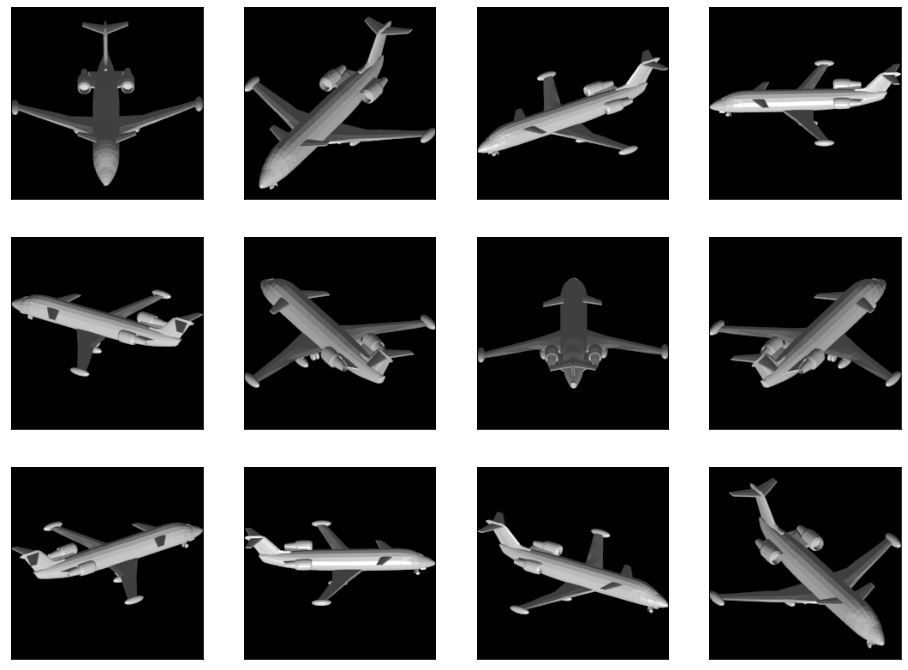

In [374]:
plt.figure(figsize=(16, 12))
i = 0
for filepath in sorted(glob.glob('./rotate_demo/origin/*.png')):
    image = io.imread(filepath)
    plt.subplot(3, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    i += 1
plt.show()

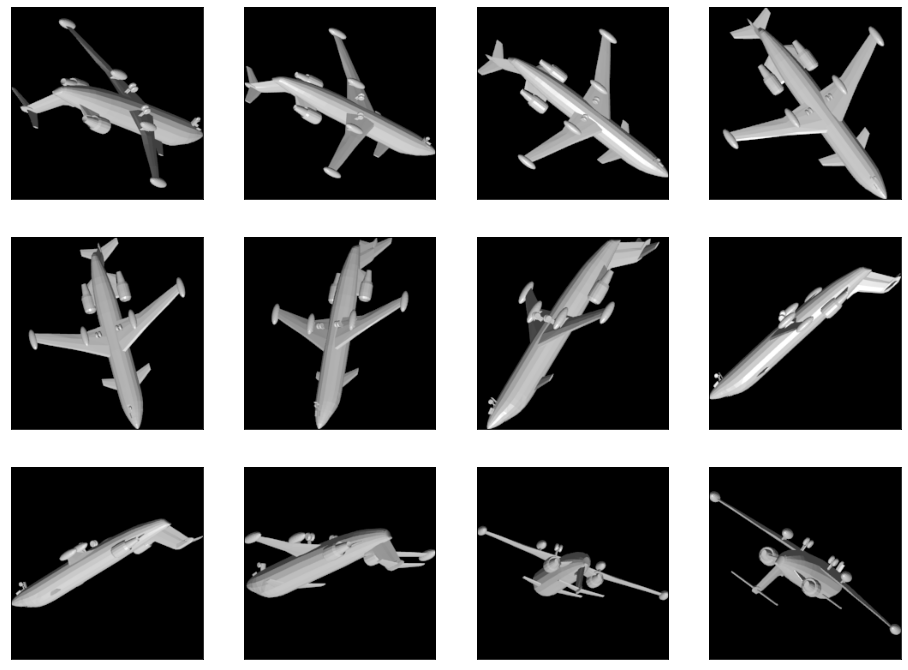

In [375]:
plt.figure(figsize=(16, 12))
i = 0
for filepath in sorted(glob.glob('./rotate_demo/rotate/*.png')):
    image = io.imread(filepath)
    plt.subplot(3, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    i += 1
plt.show()

In [386]:
rotate_gd = np.load('./rotate_gd/rotate.npy', allow_pickle=True)
rotate_gd = rotate_gd.item()
assert(len(rotate_gd) == 9449)

In [388]:
# -0.7544704151296231, -2.7441927921509723, 1.0904223423363686
rotate_gd['ModelNet40/airplane/test/airplane_0627.obj']

(-0.7544704151296231, -2.7441927921509723, 1.0904223423363686)

In [390]:
person = np.load('./rotate_gd/person.npy', allow_pickle=True)
person = person.item()
assert(len(person) == 108)

In [393]:
# # patch
# rotate_patch = {}
# pp = [k for k, v in rotate_gd.items() if k.startswith('ModelNet40/person/')]
# # fix person
# for i in p:
#     rotate_gd.pop(i)
# for k, v in person.items():
#     rotate_gd[k] = v
# # fix angle
# for k, v in rotate_gd.items():
#     rotate_patch[k] = ((v[0]+np.pi)%(2*np.pi), (v[1]-np.pi)%(2*np.pi), v[2])

In [396]:
# np.save('./rotate_gd/rotate_patched.npy', rotate_patch)

In [399]:
rotate_patch = np.load('./rotate_gd/rotate_patched.npy', allow_pickle=True)
rotate_patch = rotate_patch.item()
assert(len(rotate_patch) == 9449)

In [400]:
# 2.38712223846017, 0.3973998614388208, 1.0904223423363686
rotate_patch['ModelNet40/airplane/test/airplane_0627.obj']

(2.38712223846017, 0.3973998614388208, 1.0904223423363686)

In [432]:
import glob
import numpy as np
import PIL.Image as pil_image

import torch
from torch.utils.data import Dataset
from torchvision import transforms

class mvterDataset(Dataset):
    def __init__(self, o_root, r_root, gd, num_views=12):
        super(mvterDataset, self).__init__()

        self.classnames=['airplane',
                          #'bathtub',
                          'bed','bench','bookshelf','bottle','bowl','car','chair',
                          'cone','cup','curtain',
                          #'desk',
                          'door',
                          #'dresser',
                          'flower_pot','glass_box','guitar','keyboard','lamp','laptop','mantel',
                          #'monitor','night_stand',
                          'person','piano','plant','radio','range_hood','sink',
                          #'sofa',
                          'stairs','stool',
                          #'table',
                          'tent','toilet','tv_stand','vase','wardrobe','xbox']
        self.o_root = o_root
        self.r_root = r_root
        self.num_views = num_views
        self.gd = gd
        
        self.o_filepaths = []
        self.r_filepaths = []
        for cls in range(len(self.classnames)):
            for r_image_path in sorted(glob.glob('{}/{}/train/*.png'.format(r_root, self.classnames[cls]))):
                o_image_path = r_image_path.replace(r_root, o_root, 1)
                o_image_path = o_image_path.replace('_white', '.', 1)
                idxa = o_image_path.find('shaded_v')+8
                idxb = o_image_path.find('.png')
                o_image_path = o_image_path[:idxa]+format(int(o_image_path[idxa:idxb])+1,'03d')+'.png'
                
                self.o_filepaths.append(o_image_path)
                self.r_filepaths.append(r_image_path)

        self.transform = transforms.Compose([
#             transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
        ])

    def __getitem__(self, idx):
        o_path = self.o_filepaths[idx * self.num_views]
        r_path = self.r_filepaths[idx * self.num_views]
        class_name = o_path.split('/')[-3]
        class_id = self.classnames.index(class_name)
        
        key = 'ModelNet40/'+r_path[r_path.find(class_name):r_path.find('.obj')+4]
        euler = gd[key]
        
        # Use PIL instead
        o_imgs = []
        r_imgs = []
        for i in range(self.num_views):
            o_im = pil_image.open(self.o_filepaths[idx * self.num_views + i]).convert('RGB')
            r_im = pil_image.open(self.r_filepaths[idx * self.num_views + i]).convert('RGB')
            if self.transform:
                o_im = self.transform(o_im)
                r_im = self.transform(r_im)
            o_imgs.append(o_im)
            r_imgs.append(r_im)

        return (class_id, torch.tensor(euler), torch.stack(o_imgs), torch.stack(r_imgs), 
                self.o_filepaths[idx*self.num_views:(idx+1)*self.num_views],
                self.r_filepaths[idx*self.num_views:(idx+1)*self.num_views],)

    def __len__(self):
        return int(len(self.o_filepaths)/self.num_views)
        
train_dataset = mvterDataset('./rawdata/origin_12x', './rawdata/rotate_12x', rotate_patch)

In [433]:
train_iter = DataLoader(dataset=train_dataset,
                        batch_size=24,
                        shuffle=True,
                        pin_memory=True,
                        drop_last=True)

In [434]:
label, euler, origin, rotate, o_filepath, r_filepath = iter(train_iter).next()

In [435]:
print(origin.shape, rotate.shape, label.shape, euler.shape)

torch.Size([24, 12, 3, 224, 224]) torch.Size([24, 12, 3, 224, 224]) torch.Size([24]) torch.Size([24, 3])


In [436]:
o_filepath[0], r_filepath[0]

(('./rawdata/origin_12x/toilet/train/toilet_0213.obj.shaded_v001.png',
  './rawdata/origin_12x/toilet/train/toilet_0146.obj.shaded_v001.png',
  './rawdata/origin_12x/bed/train/bed_0352.obj.shaded_v001.png',
  './rawdata/origin_12x/glass_box/train/glass_box_0079.obj.shaded_v001.png',
  './rawdata/origin_12x/bottle/train/bottle_0074.obj.shaded_v001.png',
  './rawdata/origin_12x/airplane/train/airplane_0497.obj.shaded_v001.png',
  './rawdata/origin_12x/toilet/train/toilet_0025.obj.shaded_v001.png',
  './rawdata/origin_12x/cup/train/cup_0071.obj.shaded_v001.png',
  './rawdata/origin_12x/lamp/train/lamp_0039.obj.shaded_v001.png',
  './rawdata/origin_12x/tv_stand/train/tv_stand_0048.obj.shaded_v001.png',
  './rawdata/origin_12x/wardrobe/train/wardrobe_0024.obj.shaded_v001.png',
  './rawdata/origin_12x/tv_stand/train/tv_stand_0264.obj.shaded_v001.png',
  './rawdata/origin_12x/radio/train/radio_0075.obj.shaded_v001.png',
  './rawdata/origin_12x/tent/train/tent_0006.obj.shaded_v001.png',
  './r

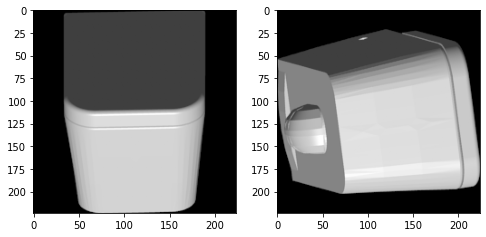

In [437]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.grid(False)
plt.imshow(origin[0, 0, ...].numpy().transpose(1, 2, 0))
plt.subplot(1,2,2)
plt.grid(False)
plt.imshow(rotate[0, 0, ...].numpy().transpose(1, 2, 0))

In [192]:
# rootdir = 'ModelNet40'
classnames = ['airplane',
              #'bathtub',
              'bed','bench','bookshelf','bottle','bowl','car','chair',
              'cone','cup','curtain',
              #'desk',
              'door',
              #'dresser',
              'flower_pot','glass_box','guitar','keyboard','lamp','laptop','mantel',
              #'monitor','night_stand',
              'person','piano','plant','radio','range_hood','sink',
              #'sofa',
              'stairs','stool',
              #'table',
              'tent','toilet','tv_stand','vase','wardrobe','xbox']

# summ = 0
# for cls in classnames:
#     num1 = len([ v for k,v in gd.items() if k.startswith(rootdir + '/' + cls + '/train')])
#     num2 = len([ v for k,v in gd.items() if k.startswith(rootdir + '/' + cls + '/test')])
#     print(cls, num1, num2)
    
# print(515 - 508 + 889 - 885)
# 
# "bed" miss 7 samples "95, 96, 125, 126, 337, 417, 453"
# "chair" miss 4 samples "92, 451, 452, 856"

# a = sorted([ int(k[-8:-4]) for k,v in gd.items() if k.startswith(rootdir + '/chair/train')])
# a = sorted(a)
# for i in range(889):
#     if a[i] != i + 1:
#         print(a[i])
#         break

airplane 626 100
bed 508 100
bench 173 20
bookshelf 572 100
bottle 335 100
bowl 64 20
car 197 100
chair 885 100
cone 167 20
cup 79 20
curtain 138 20
door 109 20
flower_pot 149 20
glass_box 171 100
guitar 155 100
keyboard 145 20
lamp 124 20
laptop 149 20
mantel 284 100
person 88 20
piano 231 100
plant 240 100
radio 104 20
range_hood 115 100
sink 128 20
stairs 124 20
stool 90 20
tent 163 20
toilet 344 100
tv_stand 267 100
vase 475 100
wardrobe 87 20
xbox 103 20


In [78]:
import torch
import torch.nn as nn
from torchvision.models import googlenet

batch_size = 24

model = googlenet(pretrained=True)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=10e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.5)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /Users/julius/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [439]:
class encoder(nn.Module):
    def __init__(self, feature_dim=2048):
        super(encoder, self).__init__()

        net = googlenet(pretrained=True)

        self.net = []
        for name, module in net.named_children():
            if isinstance(module, nn.Linear):
                self.net.append(nn.Flatten())
                continue
            self.net.append(module)

        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        x = self.net(x)
        # note: not normalized here
        return x

In [93]:
X = torch.randn(batch_size, 3, 224, 224) # N * C * H * W
for layer in encoder().net:
    X = layer(X)
    print(layer.__class__.__name__,'Output shape:\t', X.shape)

BasicConv2d Output shape:	 torch.Size([24, 64, 112, 112])
MaxPool2d Output shape:	 torch.Size([24, 64, 56, 56])
BasicConv2d Output shape:	 torch.Size([24, 64, 56, 56])
BasicConv2d Output shape:	 torch.Size([24, 192, 56, 56])
MaxPool2d Output shape:	 torch.Size([24, 192, 28, 28])
Inception Output shape:	 torch.Size([24, 256, 28, 28])
Inception Output shape:	 torch.Size([24, 480, 28, 28])
MaxPool2d Output shape:	 torch.Size([24, 480, 14, 14])
Inception Output shape:	 torch.Size([24, 512, 14, 14])
Inception Output shape:	 torch.Size([24, 512, 14, 14])
Inception Output shape:	 torch.Size([24, 512, 14, 14])
Inception Output shape:	 torch.Size([24, 528, 14, 14])
Inception Output shape:	 torch.Size([24, 832, 14, 14])
MaxPool2d Output shape:	 torch.Size([24, 832, 7, 7])
Inception Output shape:	 torch.Size([24, 832, 7, 7])
Inception Output shape:	 torch.Size([24, 1024, 7, 7])
AdaptiveAvgPool2d Output shape:	 torch.Size([24, 1024, 1, 1])
Dropout Output shape:	 torch.Size([24, 1024, 1, 1])
Flatte

In [454]:
class MVTER(nn.Module):
    def __init__(self, m=12, num_of_classes=33):
        super(MVTER, self).__init__()
        # number of view points
        self.m = m
        # GoogLeNet backbone
        self.E = nn.Sequential(*list(googlenet(pretrained=True).children())[:-1])
        # transformation decoding
        self.D = nn.Linear(2048, 3)
        # classificaton
        self.T = nn.Linear(1024, num_of_classes)
        
    def fusion(self, multiple_view_feature):
        # list of (batch_size * feature_dim)
        print(multiple_view_feature[0].shape)
        f = [torch.unsqueeze(fi, dim = 0) for fi in multiple_view_feature]
        f = torch.cat(f, dim = 0)
        pooled, _ = torch.max(f, dim = 0)
        return pooled
    
    def forward(self, im1, im2):
        f1 = self.fusion([torch.flatten(self.E(im1[:, i, ...]), start_dim=1) for i in range(self.m)])
        f2 = self.fusion([torch.flatten(self.E(im2[:, i, ...]), start_dim=1) for i in range(self.m)])
        f = torch.cat((f1, f2), dim = 1)
        return self.D(f), self.T(f1)

In [455]:
num_of_classes = 33

X1 = torch.randn(batch_size, 12, 3, 32, 32)
X2 = torch.randn(batch_size, 12, 3, 32, 32)
y1 = torch.randn(batch_size, 3)
y2 = (torch.rand(batch_size) * 33).long()

mvter = MVTER()
loss_m = nn.MSELoss()
loss_task = nn.CrossEntropyLoss()
w = 1.0
d, t = mvter(X1, X2)
loss_task(t, y2.long()) + w * loss_m(d, y1)

torch.Size([24, 1024])
torch.Size([24, 1024])


tensor(5.6211, grad_fn=<AddBackward0>)

In [161]:
models_path = "../ModelNet40"
models = glob.glob(models_path+"/*/*/*.png")
len(models)

113388

In [172]:
a = torch.ones(3, 4)
b = torch.zeros(3, 4)
c = torch.randn(3, 4) * 2

a = torch.unsqueeze(a, 0)
b = torch.unsqueeze(b, 0)
c = torch.unsqueeze(c, 0)

d = torch.cat([a, b, c], dim = 0)
values, _ = torch.max(d, dim = 0)

In [174]:
a

tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])

In [175]:
b

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])

In [176]:
c

tensor([[[ 1.9126,  1.7509, -0.4125,  2.1747],
         [-0.2753,  2.9625,  0.9194,  1.9521],
         [ 1.6368,  1.6309,  0.3008,  4.0906]]])

In [173]:
values

tensor([[1.9126, 1.7509, 1.0000, 2.1747],
        [1.0000, 2.9625, 1.0000, 1.9521],
        [1.6368, 1.6309, 1.0000, 4.0906]])